Імпортуємо всі необхідні пакети.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import normaltest, shapiro, ttest_1samp
from pandas import DataFrame

Зчитуємо дані.

In [2]:
def read_dataset(path: str):
    data = pd.read_csv(path, sep=";", encoding='cp1252')
    return data
df = read_dataset("Data2.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Region          217 non-null    object 
 2   GDP per capita  190 non-null    object 
 3   Populatiion     216 non-null    float64
 4   CO2 emission    205 non-null    object 
 5   Area            217 non-null    object 
dtypes: float64(1), object(5)
memory usage: 10.3+ KB


Внесемо усі необхідні корективи у дані:
- Приведемо числові значення до типу float;
- Заповнимо усі пропущені значення середніми;
- Виправимо від'ємні значення на додатні;
- Виправимо помилку в назві колонки.

In [3]:
def correct_floats_in_columns(df: DataFrame, list_of_columns: list[str]):
    for column in list_of_columns:
        df[column] = df[column].astype(str).str.replace(',', '.').astype(float)
    return df
correct_floats_in_columns(df, ['GDP per capita', 'CO2 emission', 'Area'])

def correct_data(df: DataFrame, list_of_columns: list[str]):
    for column in list_of_columns:
        df[column] = df[column].abs()
    df = df.fillna(df.mean(numeric_only=True))
    return df
df = correct_data(df, ['GDP per capita', 'CO2 emission', 'Area'])
df = df.rename(columns={'Populatiion': 'Population'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    217 non-null    object 
 1   Region          217 non-null    object 
 2   GDP per capita  217 non-null    float64
 3   Population      217 non-null    float64
 4   CO2 emission    217 non-null    float64
 5   Area            217 non-null    float64
dtypes: float64(4), object(2)
memory usage: 10.3+ KB


Виведемо описову статистику по нашим даним.

In [4]:
pd.options.display.float_format = '{:,.4f}'.format
df.describe()

,GDP per capita,Population,CO2 emission,Area
count,217.0000,217.0000,217.0000,217.0000
mean,"13,445.5934","34,322,559.8750","165,114.1163","618,844.1023"
std,"16,873.9221","134,447,695.4560","810,051.0953","1,827,830.4366"
min,285.7274,"11,097.0000",11.0010,2.0000
25%,"2,361.1602","795,601.0000","1,954.5110","10,887.0000"
50%,"7,179.3407","6,293,253.0000","11,562.0510","93,030.0000"
75%,"14,428.1403","23,695,919.0000","82,562.5050","447,420.0000"
max,"100,738.6842","1,378,665,000.0000","10,291,926.8800","17,098,250.0000"


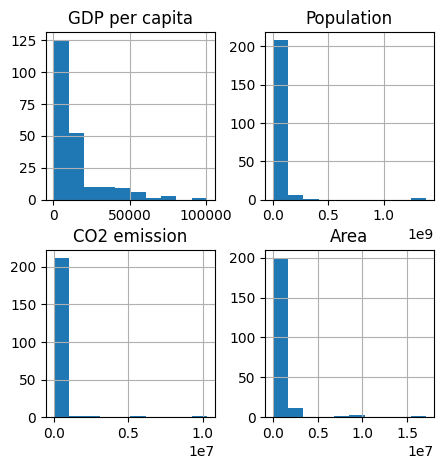

In [47]:
df.hist(figsize=(5,5))
plt.show()

Перевіримо, чи відповідають дані нормальному розподілу методом D’Agostino-Pearson.

In [7]:
def test_normal_distribution(dataframe: DataFrame, test):
    for column in (col for col in dataframe.columns if dataframe[col].dtype == float):
        _, p = test(dataframe[column])
        print("column {0} is ".format(column) + ("" if p > 0.05 else "not ") + "normally distributed with p = {0:.25f}".format(p))

test_normal_distribution(df, normaltest)

column GDP per capita is not normally distributed with p = 0.0000000000000000000000011
column Population is not normally distributed with p = 0.0000000000000000000000000
column CO2 emission is not normally distributed with p = 0.0000000000000000000000000
column Area is not normally distributed with p = 0.0000000000000000000000000


Перевіримо, чи відповідають дані нормальному розподілу за критерієм Шапіро-Уілка.

In [8]:
test_normal_distribution(df, shapiro)

column GDP per capita is not normally distributed with p = 0.0000000000000000016991852
column Population is not normally distributed with p = 0.0000000000000000000000000
column CO2 emission is not normally distributed with p = 0.0000000000000000000000000
column Area is not normally distributed with p = 0.0000000000000000000000000


Перевірити гіпотезу про рівність середнього і медіани для одного з параметрів

In [17]:
_, p_value = ttest_1samp(df['GDP per capita'], df['GDP per capita'].median())

print(f"Ми {'відхиляємо' if p_value < 0.05 else 'приймаємо'} нульову гіпотезу з {p_value=}")

Ми відхиляємо гіпотезу з p_value=1.237164116028119e-07


Тепер знайдемо регіон, у якому розподіл викидів СО2 найбільш близький до нормального


In [21]:
shapiro_results_for_emission = \
    sorted([(region, shapiro(emission)[1]) for region, emission in df.groupby("Region")["CO2 emission"]],
           key= lambda pair: pair[1], reverse=True)
print(f"Регіон з найбільш близьким розподілом викидів до нормального: {shapiro_results_for_emission[0][0]} з p_value = {shapiro_results_for_emission[0][1]}" )

Регіон з найбільш близьким розподілом викидів до нормального: North America з p_value = 0.17751772701740265


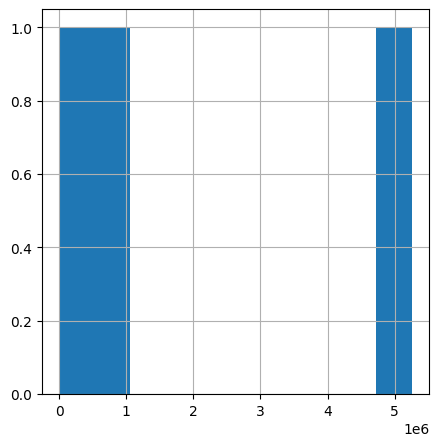

In [26]:
df.loc[(df['Region'] == "North America"), "CO2 emission"].hist(figsize=(5,5))

plt.show()

Перевіримо кількість країн в цьому регіоні, щоб зрозуміти, чи є сенс по даній вибірці робити висновки про закон розподілу.

In [28]:
print(df.loc[(df['Region'] == "North America"), "Country Name"])

21           Bermuda
35            Canada
206    United States
Name: Country Name, dtype: object


Як бачимо, таких країн лише 3, отже даних замало, щоб зробити достовірні висновки про закон розподілу.

Побудуємо кругову діаграму населення по регіонам.

<AxesSubplot: >

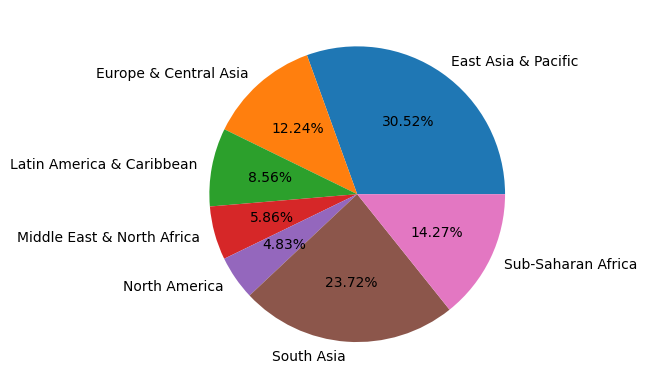

In [46]:
df.groupby(['Region']).sum(numeric_only=True).plot(kind='pie', y='Population', legend=False, ylabel="", autopct='%1.2f%%')